# Running A Backtest
In this example we will demonstrate how to run a backtest for a simple algo example

#### Loading the data bundle

In [95]:
import os

import warnings
warnings.filterwarnings('ignore')

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '.zipline')

os.listdir(os.environ['ZIPLINE_ROOT'])
import zipline
from zipline.data import bundles

bundle_name = 'alpaca_api'
bundle_data = bundles.load(bundle_name)
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal

import pandas as pd

# Set the dataloader
pricing_loader = USEquityPricingLoader.without_fx(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)


# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

start_date = pd.Timestamp('2019-07-05', tz='utc')
end_date = pd.Timestamp('2020-11-13', tz='utc')

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = start_date,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

In [96]:
import dateutil.parser
from os.path import join, exists
import pandas as pd
import pandas_datareader.data as yahoo_reader
import yaml

import numpy as np


def get_benchmark(symbol=None, start = None, end = None, other_file_path=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

In [97]:

from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt

def initialize(context):
    context.equity = equity = bundle_data.asset_finder.lookup_symbol("AMZN", end_date)

def handle_data(context, data):
    order_target(context.equity, 100)
    record(sym=data[pipeline_output.index[0][1]].price)

def before_trading_start(context, data):
    pass

def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    perf.sym.plot(ax=ax2, color='r')
    plt.gcf().set_size_inches(18, 8)
    plt.legend(['Algo', 'Benchmark'])
    plt.ylabel("Returns", color='black', size=25)


Text(0, 0.5, 'Returns')

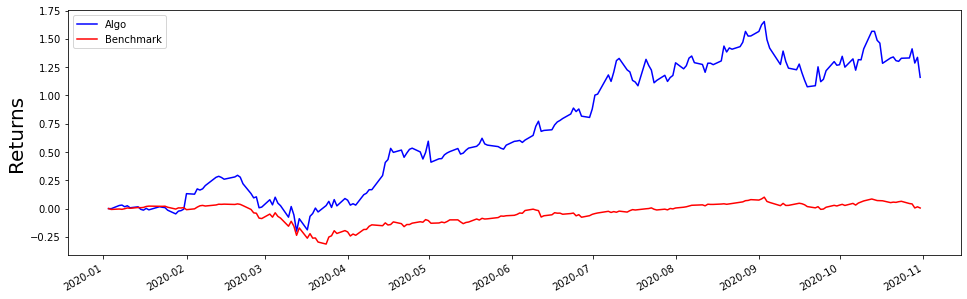

In [98]:
import pandas as pd
from datetime import datetime
import pytz

from zipline import run_algorithm

start = pd.Timestamp(datetime(2020, 1, 1, tzinfo=pytz.UTC))
end = pd.Timestamp(datetime(2020, 11, 1, tzinfo=pytz.UTC))

r = run_algorithm(start=start,
                  end=end,
                  initialize=initialize,
                  capital_base=100000,
                  handle_data=handle_data,
                  benchmark_returns=get_benchmark(symbol="SPY",
                                                  start=start.date().isoformat(),
                                                  end=end.date().isoformat()),
                  bundle='alpaca_api',
                  broker=None,
                  state_filename="./demo.state",
                  trading_calendar=trading_calendar,
                  before_trading_start=before_trading_start,
#                   analyze=analyze,
                  data_frequency='daily'
                  )
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
r.algorithm_period_return.plot(color='blue')
r.benchmark_period_return.plot(color='red')

plt.legend(['Algo', 'Benchmark'])
plt.ylabel("Returns", color='black', size=20)


# Using Pyfolio to analyze your results

In [99]:
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(r)
benchmark_returns = r.benchmark_period_return

In [100]:
import empyrical
print("returns sharp ratio: {}".format(empyrical.sharpe_ratio(returns)))  # how much is it sensative to divergance. the higher the better
print("bencmark sharp ratio: {}".format(empyrical.sharpe_ratio(benchmark_returns)))
print("beta ratio: {}".format(empyrical.beta(returns, benchmark_returns))) # how much correlation between algo to benchmark. we want it to be clsoe to zero
print("alpha ratio: {}".format(empyrical.alpha(returns, benchmark_returns))) 



returns sharp ratio: 1.7147226500268884
bencmark sharp ratio: -6.584559370521319
beta ratio: -0.010817530431739008
alpha ratio: 1.829456229577063


## Position Tear Sheet

Top 10 long positions of all time,max
sid,
AMZN,209.44%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AMZN,209.44%


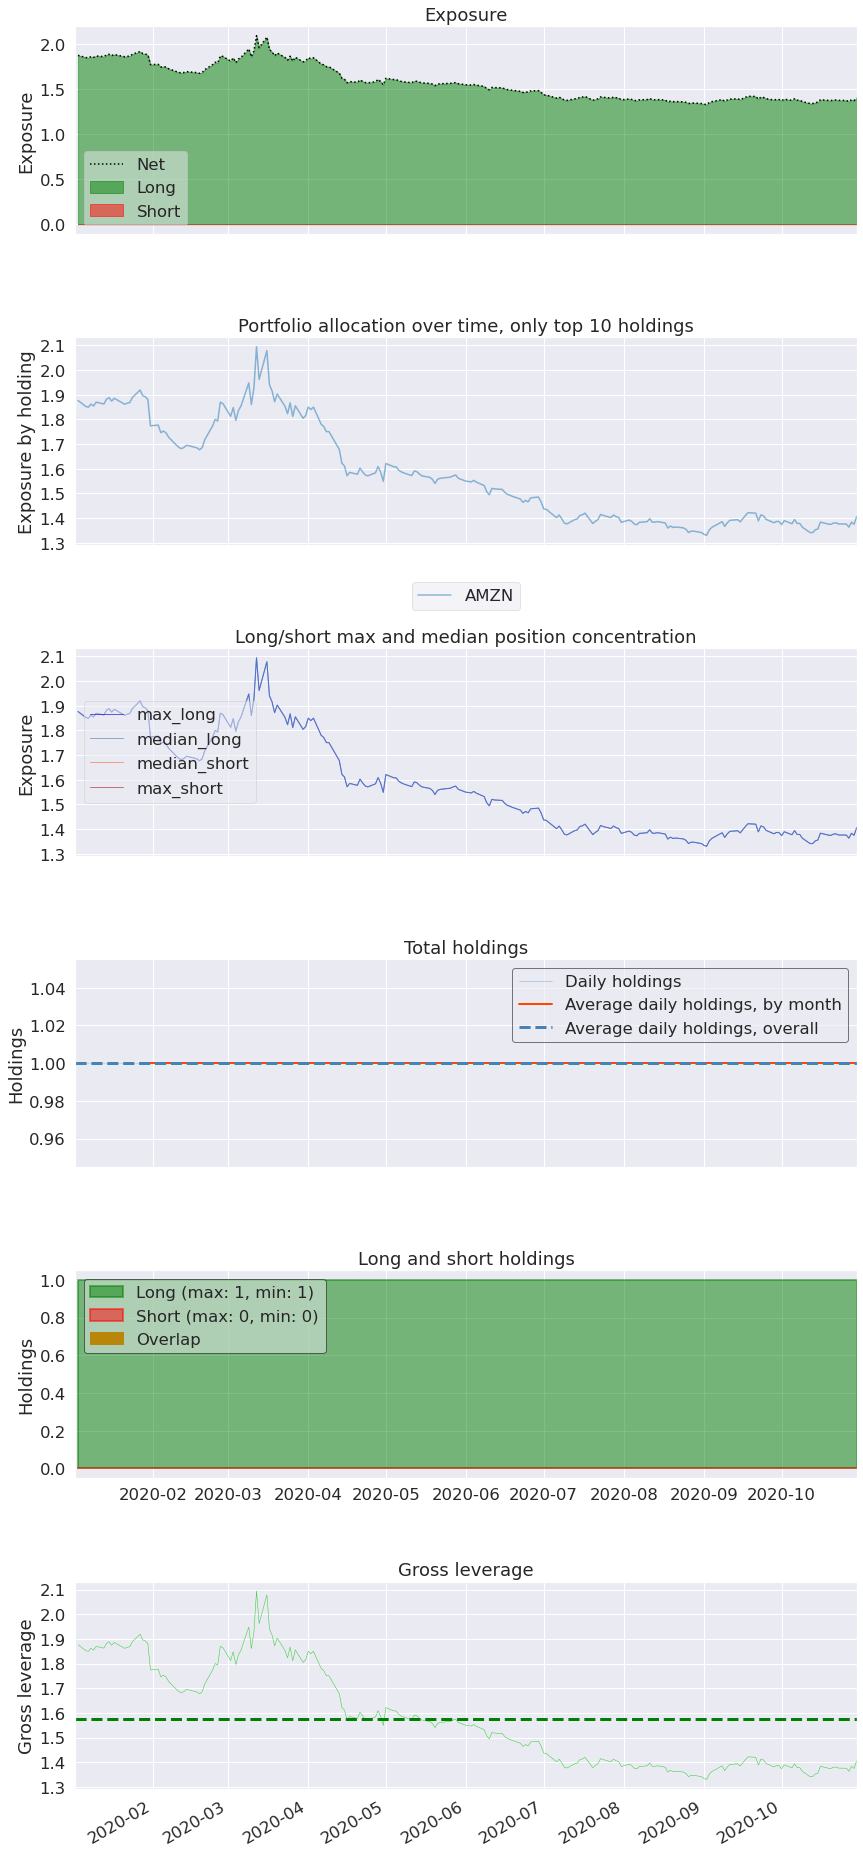

In [101]:
pf.create_position_tear_sheet(returns, positions=positions, transactions=transactions)

## Returns Tear Sheet

Start date,2020-01-02
End date,2020-10-30
Total months,10
,Backtest
Annual return,150.903%
Cumulative returns,116.026%
Annual volatility,66.542%
Sharpe ratio,1.71
Calmar ratio,3.95
Stability,0.87
Max drawdown,-38.166%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.17,2020-02-19,2020-03-12,2020-04-14,40
1,21.73,2020-09-02,2020-09-18,NaT,NaN
2,11.63,2020-04-30,2020-05-01,2020-05-20,15
3,10.39,2020-07-10,2020-07-17,2020-08-05,19
4,7.56,2020-01-07,2020-01-27,2020-01-31,19


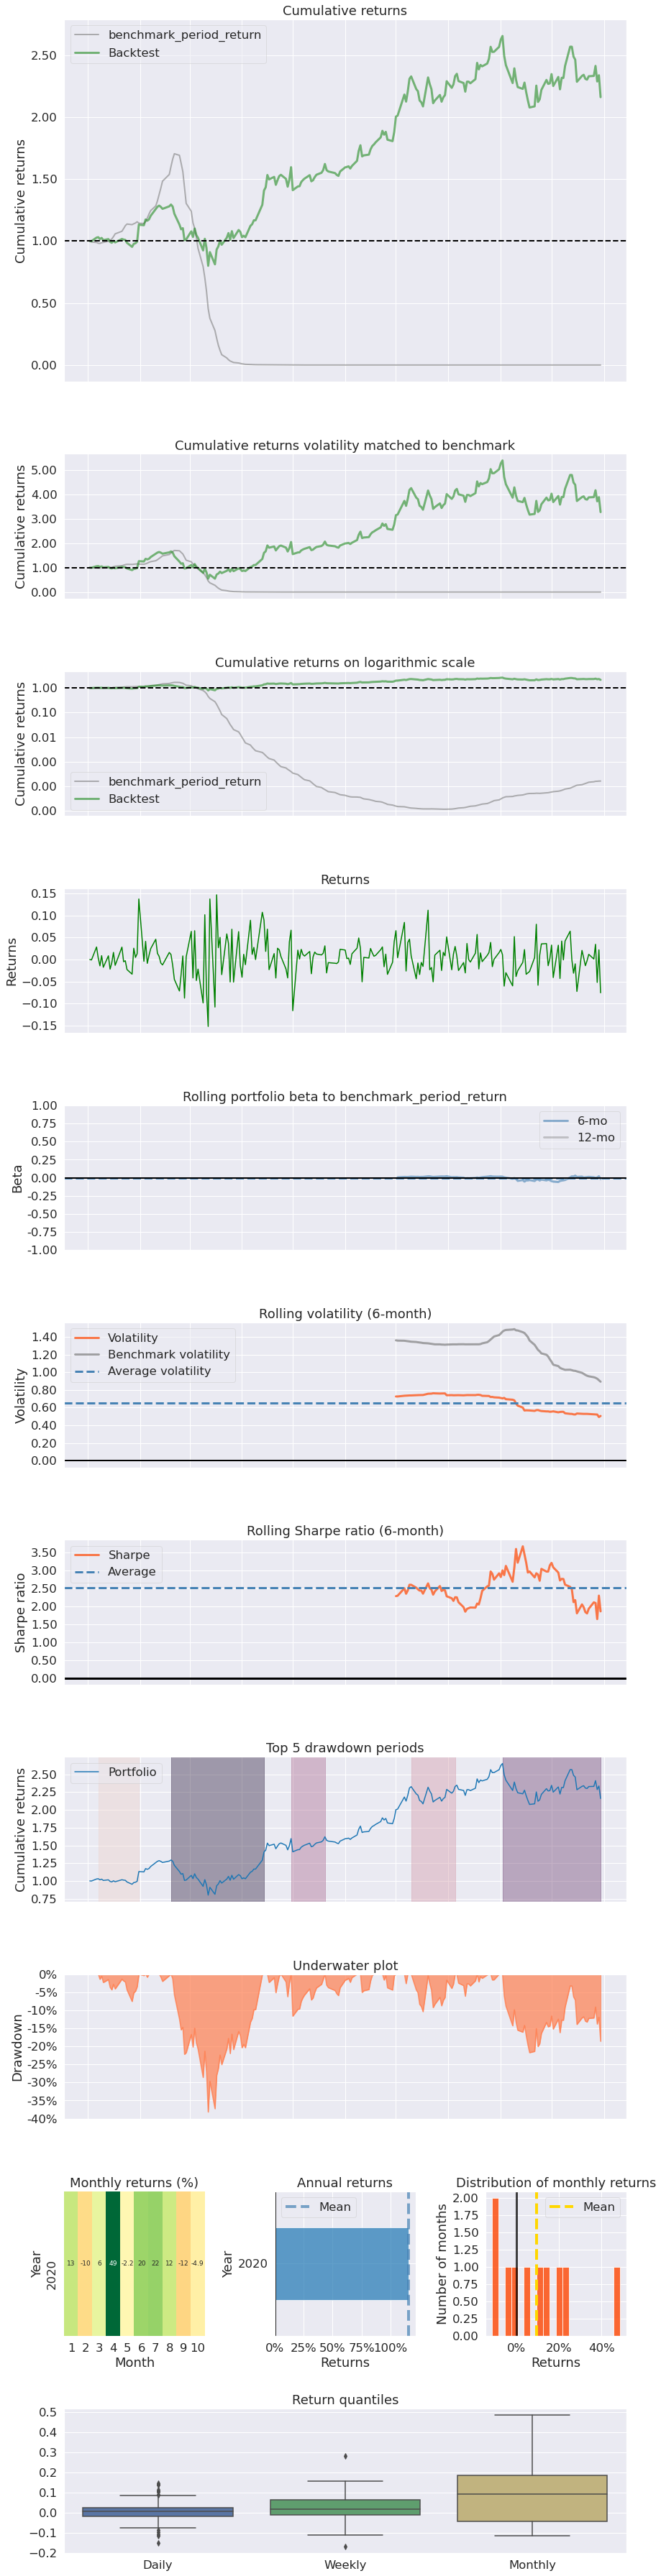

In [102]:
pf.create_returns_tear_sheet(returns, 
                             positions=positions, 
                             transactions=transactions,
                             benchmark_rets=benchmark_returns)

## Full Tear Sheet

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.17,2020-02-19,2020-03-12,2020-04-14,40
1,21.73,2020-09-02,2020-09-18,NaT,NaN
2,11.63,2020-04-30,2020-05-01,2020-05-20,15
3,10.39,2020-07-10,2020-07-17,2020-08-05,19
4,7.56,2020-01-07,2020-01-27,2020-01-31,19


Stress Events,mean,min,max
New Normal,0.45%,-15.20%,14.70%


Top 10 long positions of all time,max
sid,
AMZN,209.44%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AMZN,209.44%


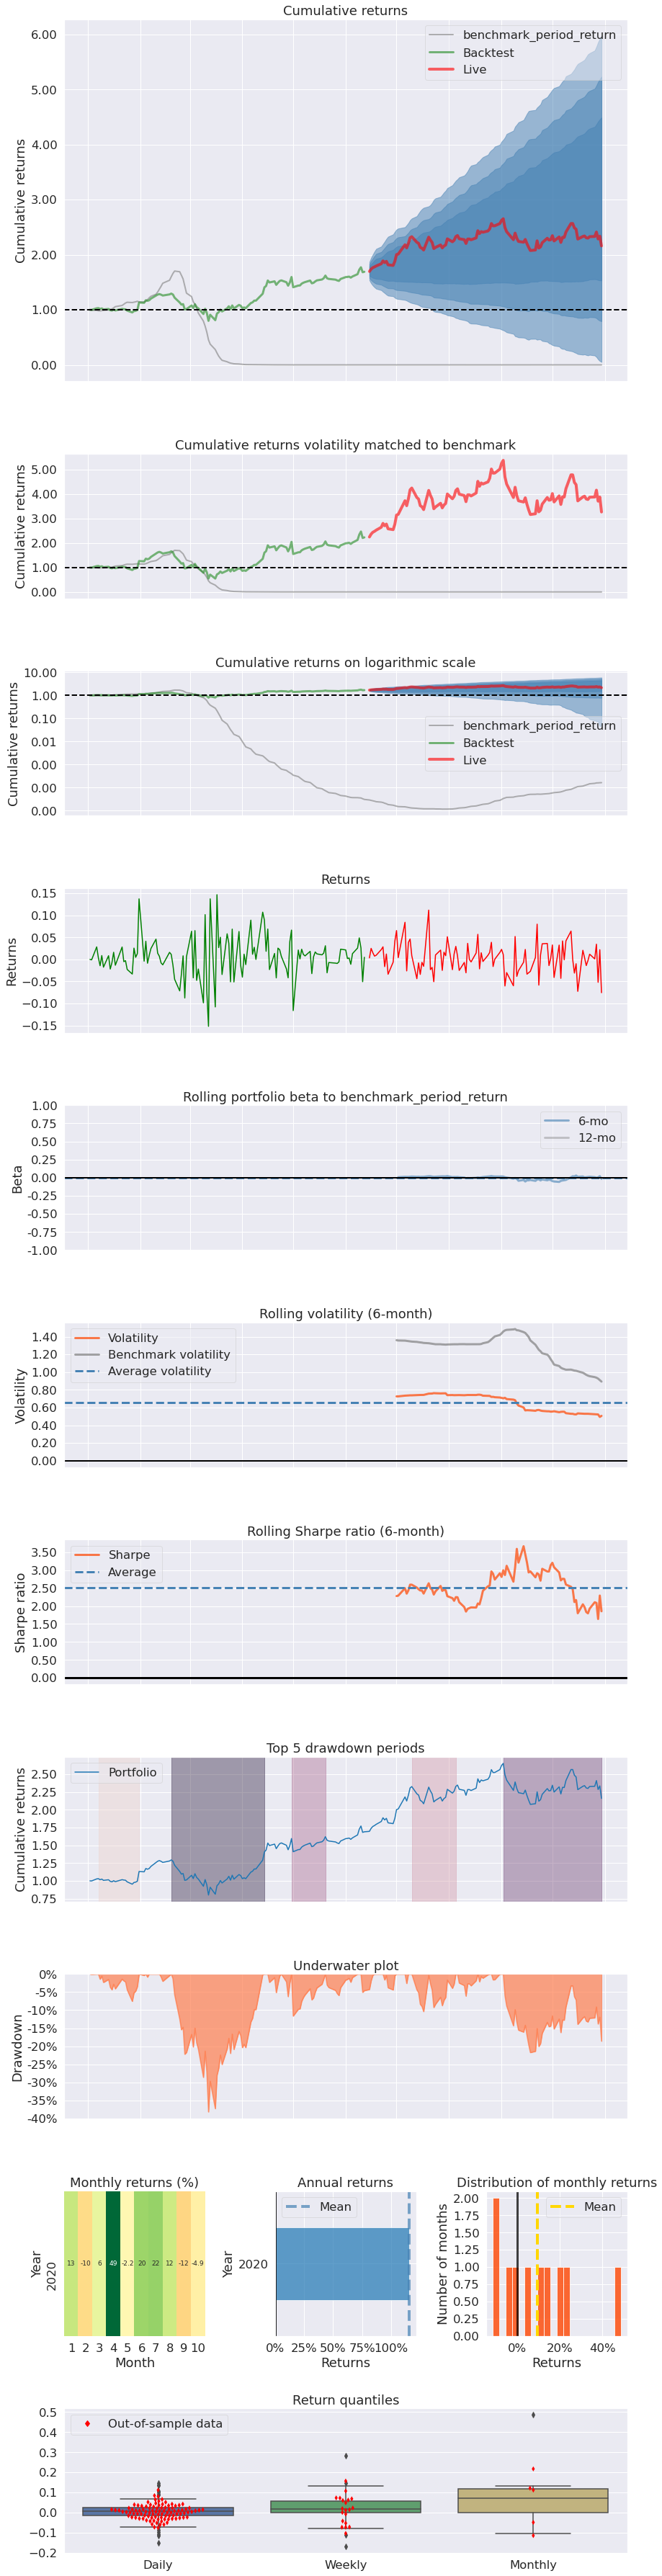

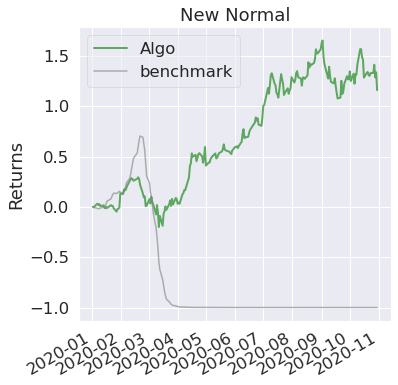

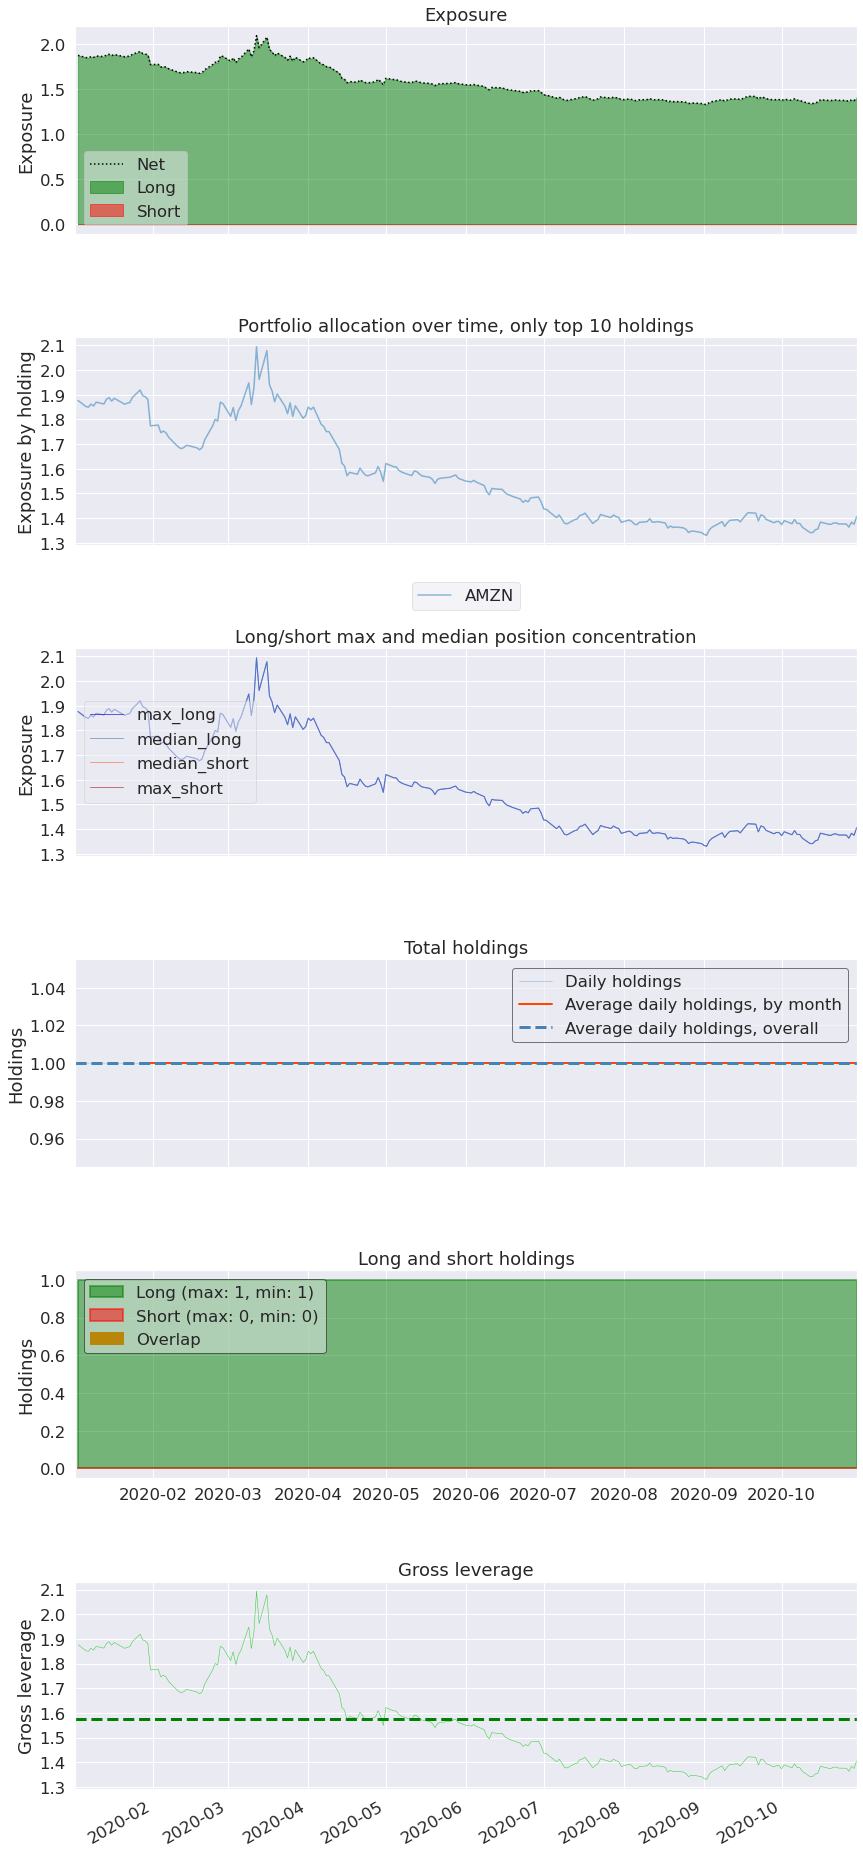

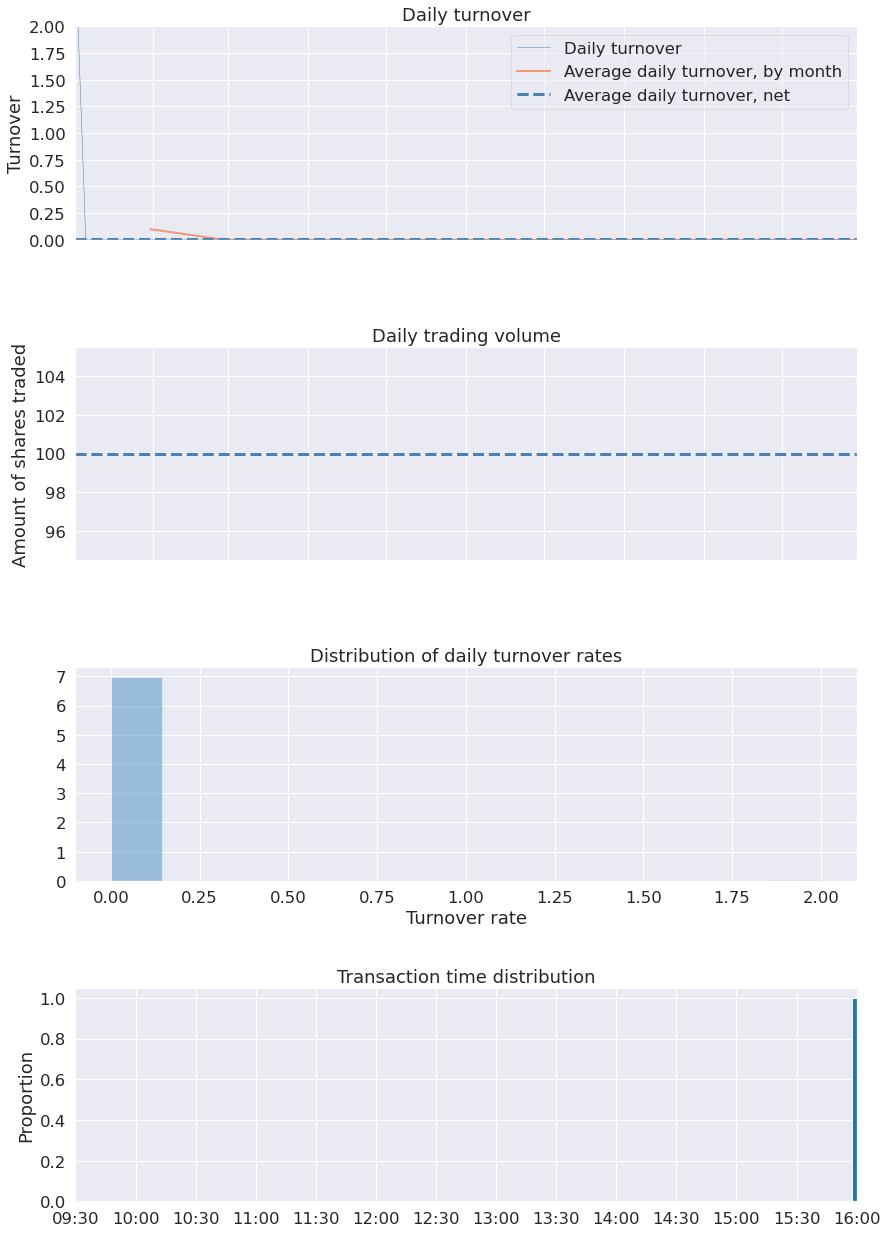

In [103]:

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,                           
                          live_start_date="2020-06-13",
                          round_trips=True, 
                          benchmark_rets=benchmark_returns)